# 유저데이터 딥러닝을 통한 질병 예측 모델 제작


## 예측 방법
> 도출해야할 결과값 : 당뇨, 대사증후군, 이상지질혈증 판정(다중분류를 이용한 동시 판정)

> 입력 데이터 : 각 질병관련 유전체, 기본 신체정보, 관련이 있다고 생각되는 일일데이터

> 방법
>> 1. 입력데이터를 이용한 혈액계측치 예측 모델 제작
>> 2. 입력데이터 및 예상혈액계측치를 이용한 질병 분류 모델 제작

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.linear_model import Ridge, LinearRegression
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf

#gpu가 텐서플로우에 인식되고 있는지 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7572591037259791776
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6964641792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17150991652265120170
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:06:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [6]:
FILE_NAME = 'datafile1.csv'
df = pd.read_csv(FILE_NAME,encoding='cp949')

df.head()

,Unnamed: 0,CID,SID,Insulin_1,CRP_1,WBC_1,Neutrophil_1,Lym_1,GLU0_1,Creatinine_1,...,DHDL,DBP,DGLU0,metabolicSyndrome,standard_Weight,diabetes,dyslipidemiaHDL,dyslipidemiaTG,dyslipidemia,category
0,0,SGA00128,MetS_S0004,7.35,0.7,5460.0,44.3,43.7,90.0,0.75,...,False,False,False,0,74.888550,0,2,0,2,2
1,1,SGA00129,MetS_S0005,4.33,0.6,4990.0,51.7,36.0,103.0,0.81,...,False,False,True,1,67.221088,1,2,0,2,3
2,2,SGA00136,MetS_S0012,6.20,0.5,5130.0,61.9,31.6,86.0,0.80,...,False,False,False,0,51.696981,0,2,0,2,2
3,3,SGA00143,MetS_S0019,7.20,0.1,4720.0,63.8,27.1,93.0,0.67,...,False,False,False,0,59.765349,0,2,0,2,2
4,4,SGA00144,MetS_S0020,6.00,0.2,5120.0,56.7,31.6,95.0,0.86,...,False,False,False,2,71.755992,0,2,2,4,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Columns: 181 entries, Unnamed: 0 to category
dtypes: bool(5), float64(32), int64(141), object(3)
memory usage: 212.6+ KB


In [14]:
gene = pd.read_excel('bigdata_healthcare_data.xlsx','유전체')
gene.drop(['CID'],axis=1,inplace=True)
list(gene.columns)

['고혈압.고혈압.전체.rs16998073',
 '고혈압.고혈압.전체.rs11191582',
 '고혈압.고혈압.전체.rs671',
 '고혈압.수축기혈압.전체.rs3790604',
 '고혈압.수축기혈압.전체.rs1731249',
 '고혈압.수축기혈압.전체.rs17046097',
 '고혈압.수축기혈압.전체.rs4684242',
 '고혈압.수축기혈압.전체.rs9814480',
 '고혈압.수축기혈압.전체.rs79581935',
 '고혈압.수축기혈압.전체.rs16896398',
 '고혈압.수축기혈압.전체.rs62525059',
 '고혈압.수축기혈압.전체.rs569550',
 '고혈압.수축기혈압.전체.rs6590811',
 '고혈압.수축기혈압.전체.rs11105364',
 '고혈압.수축기혈압.전체.rs1451538',
 '고혈압.수축기혈압.전체.rs6031431',
 '고혈압.이완기혈압.전체.rs10776752',
 '고혈압.이완기혈압.전체.rs72806698',
 '고혈압.이완기혈압.전체.rs4684242',
 '고혈압.이완기혈압.전체.rs3774427',
 '고혈압.이완기혈압.전체.rs16998073',
 '고혈압.이완기혈압.전체.rs16896398',
 '고혈압.이완기혈압.전체.rs11191871',
 '고혈압.이완기혈압.전체.rs1689040',
 '고혈압.이완기혈압.전체.rs1407040',
 '고지혈증.고콜레스테롤혈증.전체.rs151193009',
 '고지혈증.고콜레스테롤혈증.전체.rs12740374',
 '고지혈증.고콜레스테롤혈증.전체.rs13306206',
 '고지혈증.고콜레스테롤혈증.전체.rs1260326',
 '고지혈증.고콜레스테롤혈증.전체.rs75214121',
 '고지혈증.고콜레스테롤혈증.전체.rs2980875',
 '고지혈증.고콜레스테롤혈증.전체.rs1883025',
 '고지혈증.고콜레스테롤혈증.전체.rs1077835',
 '고지혈증.고콜레스테롤혈증.전체.rs9958734',
 '고지혈증.고콜레스테롤혈증.전체.rs2738464',
 '고지혈증.저H

In [16]:
inputData = df[['Waist_1','Height_1','Weight_1','BMI_1','Fat_1','Muscle_1','SEX','AGE',
              'DRINK','SMOKE','HTN','DM','DL']+list(gene.columns)]
targetData = df[['category']]
# targetTG = df[['DTG']]

In [17]:
inputData

,Waist_1,Height_1,Weight_1,BMI_1,Fat_1,Muscle_1,SEX,AGE,DRINK,SMOKE,...,당뇨.HbA1C.전체.rs2748427,당뇨.HbA1C.전체.rs8067360,당뇨.HbA1C.전체.rs59616136,당뇨.심뇌혈관질환.전체.rs139293840,비만.체질량지수비만.전체.rs6265,비만.체질량지수비만.전체.rs9939609,비만.복부비만.전체.rs10913469,비만.대사증후군.전체.rs651821,비만.대사증후군.전체.rs671,비만.대사증후군.normal_weight.rs651821
0,85.5,184.5,79.9,23.472213,16.0,36.10,1,46.0,2,1,...,0,0,0,0,-2,0,0,0,0,0
1,79.0,174.8,62.8,20.553074,11.4,28.90,1,45.0,2,3,...,0,0,0,0,-1,1,0,1,0,1
2,67.0,156.9,45.9,18.645189,13.2,18.30,0,29.0,1,1,...,1,-2,0,0,-1,0,2,1,-1,1
3,79.5,168.7,73.7,25.896276,27.6,25.40,0,32.0,2,1,...,1,0,0,0,-1,0,1,0,0,0
4,93.4,180.6,80.1,24.558228,16.2,35.90,1,42.0,2,1,...,1,-1,-1,0,-1,0,0,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,90.0,175.9,76.3,24.659988,17.5,33.00,1,34.0,2,1,...,2,-1,0,0,-1,0,0,1,0,1
150,84.5,160.2,66.2,25.794848,21.0,25.20,0,49.0,2,1,...,0,0,-2,0,0,2,0,1,0,1
151,84.0,166.9,64.0,22.975623,20.7,24.10,0,35.0,2,1,...,1,-1,-1,0,-1,1,1,1,-1,1
152,77.5,153.0,52.9,22.598146,16.4,20.36,0,44.0,2,2,...,1,0,-1,0,-1,0,2,1,-1,1


In [18]:
inputData = inputData.to_numpy()
targetData = targetData.to_numpy()
train_input, test_input, train_target, test_target = train_test_split(inputData,targetData,test_size=0.2)

In [78]:
#모델 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,input_shape=(144,),activation='selu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='selu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(8,activation='softmax')
])

In [79]:
from tensorflow.keras.optimizers import SGD,Adam,Nadam
adam = Adam(learning_rate = 0.00001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
history = model.fit(train_input, train_target, epochs=20, validation_split=0.2)

Epoch 1/20
4/4 [==============================] - 1s 81ms/step - loss: 14.1724 - accuracy: 0.1531 - val_loss: 11.9013 - val_accuracy: 0.2000
Epoch 2/20
4/4 [==============================] - 0s 17ms/step - loss: 18.3498 - accuracy: 0.1020 - val_loss: 5.0515 - val_accuracy: 0.1600
Epoch 3/20
4/4 [==============================] - 0s 16ms/step - loss: 3.6307 - accuracy: 0.2041 - val_loss: 2.0723 - val_accuracy: 0.2800
Epoch 4/20
4/4 [==============================] - 0s 16ms/step - loss: 2.4353 - accuracy: 0.2041 - val_loss: 2.0705 - val_accuracy: 0.2800
Epoch 5/20
4/4 [==============================] - 0s 17ms/step - loss: 2.2586 - accuracy: 0.2143 - val_loss: 2.0686 - val_accuracy: 0.2800
Epoch 6/20
4/4 [==============================] - 0s 18ms/step - loss: 2.0925 - accuracy: 0.3061 - val_loss: 3.2494 - val_accuracy: 0.1600
Epoch 7/20
4/4 [==============================] - 0s 19ms/step - loss: 2.3943 - accuracy: 0.2959 - val_loss: 2.0657 - val_accuracy: 0.2800
Epoch 8/20
4/4 [========

In [ ]:
loss, accuracy = model.evaluate(test_input, test_target)
print(loss, accuracy)

In [14]:
poly = PolynomialFeatures(degree = 3, include_bias = False)
poly.fit(train_inputTG)
train_polyTG = poly.transform(train_inputTG)
test_polyTG = poly.transform(test_inputTG)

In [15]:
#전체적으로 다 낮은 정확도를 보이지만 RobustScaler가 트레인데이터와 테스트데이터 정확도에서 가장 적은 차이를 보임

# ss = StandardScaler()
# ss.fit(train_inputTG)
# train_scaledTG = ss.transform(train_inputTG)
# test_scaledTG = ss.transform(test_inputTG)

# mms = MinMaxScaler()
# mms.fit(train_inputTG)
# train_scaledTG = mms.transform(train_inputTG)
# test_scaledTG = mms.transform(test_inputTG)

rs = RobustScaler()
rs.fit(train_polyTG)
train_scaledTG = rs.transform(train_polyTG)
test_scaledTG = rs.transform(test_polyTG)

In [16]:
ridge = Ridge()
ridge.fit(train_scaledTG, train_targetTG)
print(ridge.score(train_scaledTG, train_targetTG),ridge.score(test_scaledTG, test_targetTG))

0.2714018030905818 -1.2338182813287863


In [17]:
lr = LinearRegression()
lr.fit(train_scaledTG, train_targetTG)
print(lr.score(train_scaledTG, train_targetTG),lr.score(test_scaledTG, test_targetTG))

0.48459404357372193 -9.719245530551282


In [9]:
print(ridge.coef_)

[[ 16.70309176 -16.76631754  51.7601605   18.28738501 -33.63225373]]


In [18]:
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
trainScore = []
testScore = []
for alpha in alpha_list:
    ridge = Ridge(alpha = alpha)
    ridge.fit(train_scaledTG,train_targetTG)
    trainScore.append(ridge.score(train_scaledTG, train_targetTG))
    testScore.append(ridge.score(test_scaledTG, test_targetTG))

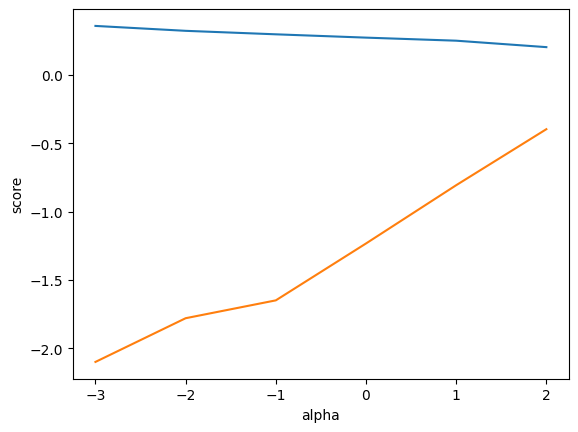

In [19]:
plt.plot(np.log10(alpha_list), trainScore)
plt.plot(np.log10(alpha_list),testScore)
plt.xlabel('alpha')
plt.ylabel('score')
plt.show()

In [25]:
rs = RobustScaler()
rs.fit(train_inputTG)
train_scaledTG = rs.transform(train_inputTG)
test_scaledTG = rs.transform(test_inputTG)

In [42]:
#모델 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16,input_dim=5,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [43]:
model.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
history = model.fit(train_inputTG, train_targetTG, epochs=14, validation_split=0.2)

Epoch 1/14
4/4 [==============================] - 1s 74ms/step - loss: 12.3605 - accuracy: 0.6633 - val_loss: 5.1039 - val_accuracy: 0.7600
Epoch 2/14
4/4 [==============================] - 0s 20ms/step - loss: 13.0812 - accuracy: 0.6633 - val_loss: 3.8664 - val_accuracy: 0.7600
Epoch 3/14
4/4 [==============================] - 0s 19ms/step - loss: 10.7516 - accuracy: 0.6531 - val_loss: 2.6670 - val_accuracy: 0.7600
Epoch 4/14
4/4 [==============================] - 0s 19ms/step - loss: 8.4623 - accuracy: 0.6633 - val_loss: 1.5852 - val_accuracy: 0.7600
Epoch 5/14
4/4 [==============================] - 0s 20ms/step - loss: 10.9693 - accuracy: 0.6633 - val_loss: 1.1078 - val_accuracy: 0.7600
Epoch 6/14
4/4 [==============================] - 0s 18ms/step - loss: 6.0014 - accuracy: 0.6633 - val_loss: 0.8664 - val_accuracy: 0.7600
Epoch 7/14
4/4 [==============================] - 0s 20ms/step - loss: 5.9558 - accuracy: 0.6633 - val_loss: 0.8382 - val_accuracy: 0.7600
Epoch 8/14
4/4 [=======

In [45]:
loss, accuracy = model.evaluate(test_inputTG, test_targetTG)
print(loss, accuracy)

1/1 [==============================] - 0s 24ms/step - loss: 0.6569 - accuracy: 0.7419
0.6568722724914551 0.7419354915618896


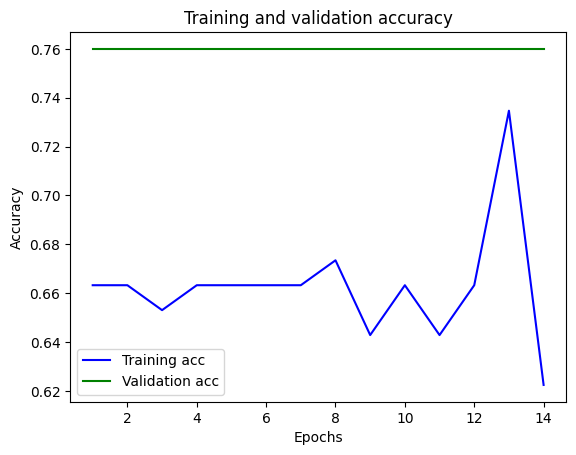

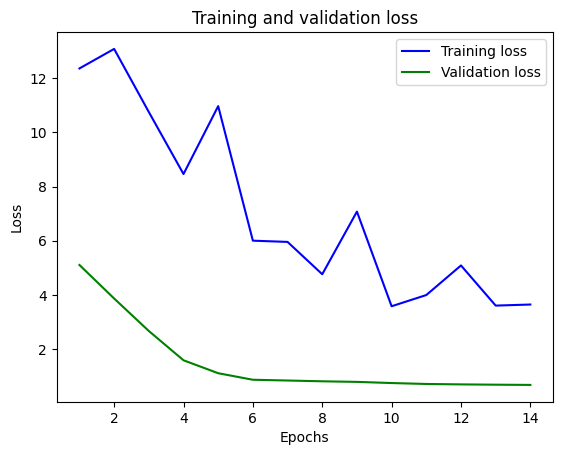

In [46]:
# Plotting Results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
#모델 구성
binaryModel = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,input_shape=(5,),activation='relu'),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='relu')
])

In [ ]:
binaryModel.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = binaryModel.fit(train_inputTG, train_targetTG, epochs=20, validation_split=0.2)

In [ ]:
loss, accuracy = model.evaluate(test_inputTG, test_targetTG)
print(loss, accuracy)

In [ ]:
# Plotting Results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()